In [49]:
# Preliminaries

## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    %pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/tmp/ipykernel_1334066/2431712474.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0
Number of workers: 64


In [50]:
### Libraries for reading the files

from PIL import Image, ImageFilter
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
import scipy
from scipy import ndimage
import cv2
import copy
import tqdm
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [51]:
# [1] Read the Zno Magnification Dataset

#600W
df600W = pd.read_csv('data/all600Wdata.csv')
#100W200W
df100W200W = pd.read_csv('data/alltrialhavemag.csv')

#Merge all csvs
alldf = pd.concat([df100W200W, df600W], ignore_index=True)
pd.set_option('display.max_rows', alldf.shape[0]+1)

#For base model, consider only the images with mag = 10000
df = alldf[alldf.mag == 10000]                                          #Change the magnification here!
#df = alldf
print(df.mag.unique())

#Represent the actual output as y
dfpower, dftime = np.array(df.mp), np.array(df.mt)
y = np.stack((dfpower, dftime), axis=-1)

#Represent the images as X
df['rootpath'] = df['rootpath'].apply(lambda x: x.lstrip("../../"))
X = np.array(df['rootpath'] + "/" + df['file'])

#Combine X and y for splitting later
df_labeled = np.stack((X,dfpower, dftime), axis=-1)
df_labeled

#Split the data
train_list, test_list = train_test_split(df_labeled, test_size=0.3, random_state=0, shuffle=True)

[10000]


/tmp/ipykernel_1334066/724446789.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rootpath'] = df['rootpath'].apply(lambda x: x.lstrip("../../"))


In [52]:
# [A2.i]: Create the augmentation code class
class ContrastiveTransformations:

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

    @staticmethod
    def augmentation(img):
        img = img.crop((0, 0, 1280, 960))  # Removes the details below the image
        augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Do a random horizontal flip
            transforms.RandomResizedCrop(size=224),  # Reduce the size to 224, i.e. resnet18 prefered size
            transforms.RandomApply([  # Randomly apply color jitter
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
            ], p=0.8),
            transforms.GaussianBlur(kernel_size=9),  # Randomly perform Gaussian blur
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Convert everything to tensor
        ])

        return augment(img)

    def img_augmentation(df, n_views=2):
        new_X = []
        power = []
        time = []
    
        for i in range(df.shape[0]):
            # Open the image for specified cropping in the function
            img = Image.open(df[i][0])

            # Create an instance of ContrastiveTransformations with the desired number of views
            augmentation_transform = ContrastiveTransformations(ContrastiveTransformations.augmentation, n_views=n_views)
            
            # Retrieve n_views augmented views using the transformation process
            augmented_views = augmentation_transform(img)  # This will be a list of n_views tensors
            view1, view2 = augmented_views[0], augmented_views[1]
            view1 = np.repeat(view1[...,np.newaxis],3,-1)
            view2 = np.repeat(view2[...,np.newaxis],3,-1)
            #print(augmented_views)
            
            # Append the augmented views to new_X
            new_X.extend(view1)  # This will add all augmented views to the list
            new_X.extend(view2)

            # Append the power and time labels for each view
            power.extend([df[i][1]] * n_views)  # Repeat power label for each view
            time.extend([df[i][2]] * n_views)  # Repeat time label for each view

        # Stack the new views to form a single tensor (shape: [n_views * batch_size, 3, 224, 224])
        new_X = torch.stack(new_X, dim=0)
        #new_X = new_X.unsqueeze(2) # Stack views along batch dimension
        new_X = torch.permute(new_X,(0,3,1,2))

        #Map the values for the power and time
        mapping_GT = {2:0, 3:1, 5:2, 10:3, 15:4}
        mapping_MP = {100:0, 200:1, 600:2}
        power = [mapping_MP[item] for item in power]
        time = [mapping_GT[item] for item in time]
        power = torch.tensor(power)
        time = torch.tensor(time)

        # Now return the stacked views along with the labels
        return new_X, power, time

# Transform the data split
train_X, train_MP, train_GT = ContrastiveTransformations.img_augmentation(train_list, n_views=2)
test_X, test_MP, test_GT  = ContrastiveTransformations.img_augmentation(test_list, n_views=2)

print(train_X.shape)
print(train_MP.shape)
print(train_GT.shape)


torch.Size([62, 3, 224, 224])
torch.Size([62])
torch.Size([62])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18431371..0.15294123].


<Figure size 640x480 with 0 Axes>

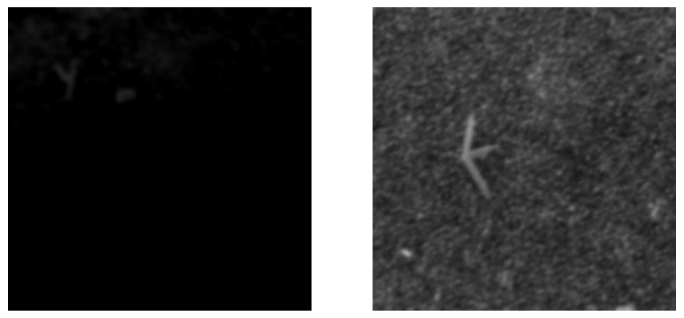

In [53]:
# Convert the tensors to numpy arrays and transpose the dimensions to (224, 224, 3)
image1 = train_X[10].permute(1, 2, 0).numpy()
image2 = train_X[11].permute(1, 2, 0).numpy()

# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the images in the subplots
ax[0].imshow(image1)
ax[0].axis('off')  # Hide axes for the first image

ax[1].imshow(image2)
ax[1].axis('off')  # Hide axes for the second image

# Show the images
plt.show()

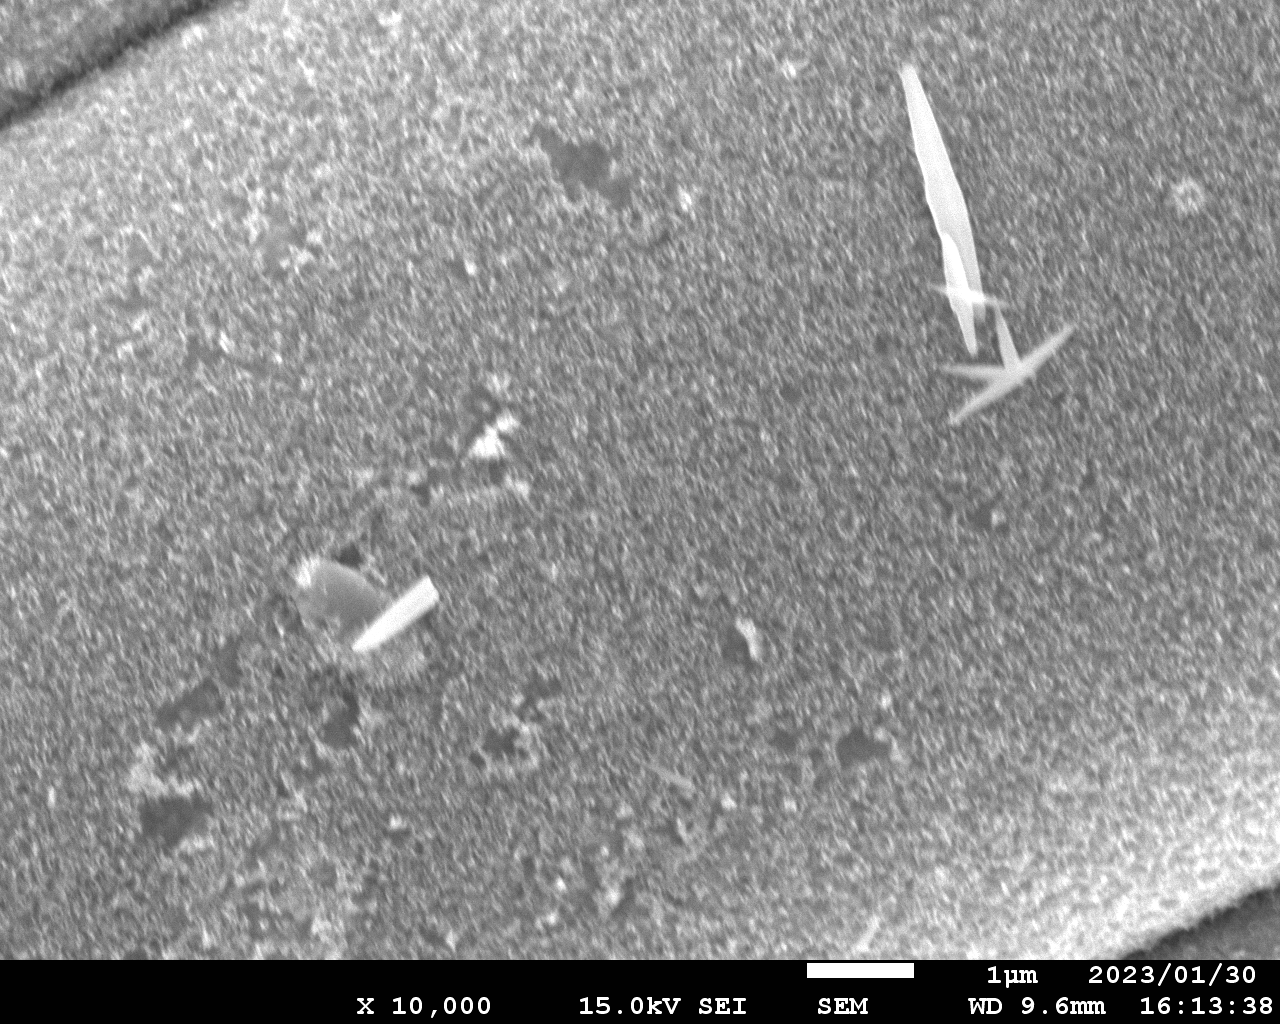

In [54]:
Image.open(train_list[0][0])

In [55]:
#Working Model

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=1000, fine_tune=False):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Initialize the base ResNet50 model with pretrained weights
        self.convnet = torchvision.models.resnet50(pretrained=True)

        # Optionally, freeze the layers if fine_tune is False (you can control this during initialization)
        if not fine_tune:
            for param in self.convnet.parameters():
                param.requires_grad = False

        # Replace the fully connected layer (fc) with a projection head
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)
        )

        #self.convnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        
        # Initialize the projection head layers from scratch
        self._initialize_projection_head()

    def _initialize_projection_head(self):
        # Initialize projection head layers (custom `fc` layer)
        for m in self.convnet.fc:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def configure_optimizers(self):
        # Use AdamW optimizer
        optimizer = optim.AdamW(self.parameters(),
                                 lr=self.hparams.lr,
                                 weight_decay=self.hparams.weight_decay)
        # Use CosineAnnealingLR for learning rate scheduler
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                             T_max=self.hparams.max_epochs,
                                                             eta_min=self.hparams.lr / 50)
        return [optimizer], [lr_scheduler]

    def forward(self, x):
        #x = self.modify_input_channels(x)
        feats = self.convnet(x)  # Feature extraction from ResNet backbone
        #print(feats)
        return feats
    
    def info_nce_loss(self, batch, mode='train'):
        imgs = batch
        #print(imgs.size)
        imgs = tuple(imgs)
        imgs = torch.cat(imgs, dim=0)

        # Encode all images using the ResNet18 backbone
        feats = self.convnet(imgs)

        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll)

        # Get ranking position of positive example
        comb_sim = torch.cat([ cos_sim[pos_mask][:, None],  # First position positive example
                             cos_sim.masked_fill(pos_mask, -9e15)],
                            dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # Logging ranking metrics
        top1_accuracy = (sim_argsort == 0).float().mean()
        top5_accuracy = (sim_argsort < 5).float().mean()
        mean_pos = 1 + sim_argsort.float().mean()

        self.log(mode + '_acc_top1', top1_accuracy)
        self.log(mode + '_acc_top5', top5_accuracy)
        self.log(mode + '_acc_mean_pos', mean_pos)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def test_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='test')


In [56]:
#Fine-tune the model

# Define DataLoader for training set
dataset_train = data.TensorDataset(train_X)
train_loader = data.DataLoader(dataset_train, batch_size=16, shuffle=True,
                                               drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    
# Test best model on validation set
dataset_test = data.TensorDataset(test_X)
test_loader = data.DataLoader(dataset_test, batch_size=16, shuffle=False,
                                              drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=500, fine_tune=True) #HAHAHA POTA DI KO NAPALITAN

# Initialize the PyTorch Lightning Trainer
simclr_trainer = pl.Trainer(
    max_epochs=500,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
        LearningRateMonitor('epoch')
    ]
)

# Train the model
simclr_trainer.fit(simclr_model, train_loader)

# Save the model after training
#model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

/home/aldie/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aldie/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/aldie/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/aldie/miniconda3/lib/python3.12/site-packages/ ...
GPU available

Epoch 499: 100%|██████████| 3/3 [00:17<00:00,  0.18it/s, v_num=170]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 3/3 [00:17<00:00,  0.18it/s, v_num=170]


In [57]:
model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07,weight_decay=1e-4)
print(model)

SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [58]:
#Saves the model and fine-tuned weights
torch.save(simclr_model.state_dict(), 'MB_savedlogs/SIMCLR-v1-epoch500-trueFT.pth') #Start with v3 tomorrow, or the date yey
print('Model saved!')

#Checks the accuracy for test data
simclr_trainer.test(simclr_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 56.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_acc_mean_pos     │    6.8214287757873535     │
│       test_acc_top1       │    0.2142857164144516     │
│       test_acc_top5       │    0.4285714328289032     │
│         test_loss         │     2.574568271636963     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.574568271636963,
  'test_acc_top1': 0.2142857164144516,
  'test_acc_top5': 0.4285714328289032,
  'test_acc_mean_pos': 6.8214287757873535}]

In [59]:
class MultiOutputRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes_time, num_classes_power, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()

        # Model with two output layers: one for time and one for power
        self.model_time = nn.Linear(feature_dim, num_classes_time)
        self.model_power = nn.Linear(feature_dim, num_classes_power)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, time, power = batch
        
        # Forward pass for both outputs
        preds_time = self.model_time(feats)
        preds_power = self.model_power(feats)
        
        # Calculate MSE loss for both outputs
        loss_time = F.cross_entropy(preds_time, time)
        loss_power = F.cross_entropy(preds_power, power)
        
        # Combine the losses (you can weight them if needed)
        total_loss = loss_time + loss_power
        
        #Get accuracy separately
        GT_acc = (preds_time.argmax(dim=-1) == time).float().mean()
        MP_acc = (preds_power.argmax(dim=-1) == time).float().mean()

        # Logging metrics
        self.log(mode + '_loss_time', loss_time)
        self.log(mode + '_loss_power', loss_power)
        self.log(mode + '_loss_total', total_loss)
        self.log(mode + '_GT_acc', GT_acc)
        self.log(mode + '_MP_acc', MP_acc)
        
        return total_loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='test')

In [60]:
model2 = MultiOutputRegression(feature_dim=128, num_classes_power=3, num_classes_time=5, lr = 0.003, weight_decay=0.05)
print(model2)

MultiOutputRegression(
  (model_time): Linear(in_features=128, out_features=5, bias=True)
  (model_power): Linear(in_features=128, out_features=3, bias=True)
)


In [61]:
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, GT_label, MP_label = [], [], []
    for batch_imgs, batch_GT_label, batch_MP_label in tqdm.tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        GT_label.append(batch_GT_label)
        MP_label.append(batch_MP_label)

    feats = torch.cat(feats, dim=0)
    GT_label = torch.cat(GT_label, dim=0)
    MP_label = torch.cat(MP_label, dim=0)

    #Return them properly
    final_dset = data.TensorDataset(feats, GT_label, MP_label)
    return data.DataLoader(final_dset, batch_size = 64, shuffle = False, drop_last = False, pin_memory=True, num_workers=NUM_WORKERS)

In [62]:
# Define DataLoader for training set
dataset_train = data.TensorDataset(train_X, train_GT, train_MP)
    
# Test best model on validation set
dataset_test = data.TensorDataset(test_X, test_GT, test_MP)

#Convert them
train_feats_simclr = prepare_data_features(model, dataset_train)
test_feats_simclr = prepare_data_features(model, dataset_test)

100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


In [63]:
#Fine-tune the LogReg model for label prediction

logreg_model = MultiOutputRegression(feature_dim=2048, num_classes_power=3, num_classes_time=5, lr=5e-4, weight_decay=1e-4) 
# Initialize the PyTorch Lightning Trainer
logreg_trainer = pl.Trainer(
    max_epochs=500, 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode='max'),
        LearningRateMonitor('epoch')
    ]
)

# Train the model
logreg_trainer.fit(logreg_model, train_feats_simclr)

# Save the model after training
#model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aldie/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type   | Params | Mode 
-----------------------------------------------
0 | model_time  | Linear | 10.2 K | train
1 | model_power | Linear | 6.1 K  | train
-----------------------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


/home/aldie/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 1/1 [00:14<00:00,  0.07it/s, v_num=186]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:14<00:00,  0.07it/s, v_num=186]


In [64]:
#Saves the model and fine-tuned weights
torch.save(simclr_model.state_dict(), 'MB_savedlogs/LOGREG-v1-epoch500-trueFT.pth') #Start with v3 tomorrow, or the date yey
print('Model saved!')

logreg_trainer.test(logreg_model, test_feats_simclr)

/home/aldie/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/aldie/miniconda3/lib/python3.12/site-packages/ ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_GT_acc        │            0.5            │
│        test_MP_acc        │    0.1071428656578064     │
│      test_loss_power      │    0.6642795205116272     │
│      test_loss_time       │     1.171141505241394     │
│      test_loss_total      │    1.8354212045669556     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_time': 1.171141505241394,
  'test_loss_power': 0.6642795205116272,
  'test_loss_total': 1.8354212045669556,
  'test_GT_acc': 0.5,
  'test_MP_acc': 0.1071428656578064}]

In [ ]:
epochs = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

for epoch in epochs:
    print(f"EPOCH {epoch} Training and Testing")
    #Fine-tune the model
    simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5000, fine_tune=True) #HAHAHA POTA DI KO NAPALITAN

# Initialize the PyTorch Lightning Trainer
    simclr_trainer = pl.Trainer(
        max_epochs=epoch,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
            LearningRateMonitor('epoch')
        ]
    )

    # Train the model
    simclr_trainer.fit(simclr_model, train_loader)
    
    #Saves the model and fine-tuned weights
    torch.save(simclr_model.state_dict(), f'MB_savedlogs/SIMCLR-v1-epoch{epoch}-trueFT.pth') #Start with v3 tomorrow, or the date yey
    print('Model saved!')

    #Checks the accuracy for test data
    simclr_trainer.test(simclr_model, test_loader)

    #Fine-tune the LogReg model for label prediction
    logreg_model = MultiOutputRegression(feature_dim=2048, num_classes_power=3, num_classes_time=5, lr=5e-4, weight_decay=1e-4) 
    
    # Initialize the PyTorch Lightning Trainer
    logreg_trainer = pl.Trainer(
        max_epochs=epoch, 
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode='max'),
            LearningRateMonitor('epoch')
        ]
    )

    # Train the model
    logreg_trainer.fit(logreg_model, train_feats_simclr)

    #Saves the model and fine-tuned weights
    torch.save(simclr_model.state_dict(), f'MB_savedlogs/LOGREG-v1-epoch{epoch}-trueFT.pth') #Start with v3 tomorrow, or the date yey
    print('Model saved!')

    #Check accuracy for test data
    logreg_trainer.test(logreg_model, test_feats_simclr)


EPOCH 1000 Training and Testing


/home/aldie/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aldie/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 24.6 M | train
-------------------------------------------
24.6 M    Trainable params
0

Epoch 999: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=204]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:12<00:00,  0.24it/s, v_num=204]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 57.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_acc_mean_pos     │    6.9285712242126465     │
│       test_acc_top1       │    0.1071428582072258     │
│       test_acc_top5       │    0.3571428656578064     │
│         test_loss         │    2.5751001834869385     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aldie/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type   | Params | Mode 
-----------------------------------------------
0 | model_time  | Linear | 10.2 K | train
1 | model_power | Linear | 6.1 K  | train
-----------------------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/home/aldie/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_step

Epoch 999: 100%|██████████| 1/1 [00:13<00:00,  0.07it/s, v_num=211]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:13<00:00,  0.07it/s, v_num=211]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_GT_acc        │    0.4285714626312256     │
│        test_MP_acc        │    0.1071428656578064     │
│      test_loss_power      │     0.642231285572052     │
│      test_loss_time       │    1.2067703008651733     │
│      test_loss_total      │    1.8490016460418701     │
└───────────────────────────┴───────────────────────────┘

EPOCH 1500 Training and Testing


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 24.6 M | train
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Epoch 1499: 100%|██████████| 3/3 [00:09<00:00,  0.32it/s, v_num=215]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 3/3 [00:09<00:00,  0.32it/s, v_num=215]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 46.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_acc_mean_pos     │     7.714285850524902     │
│       test_acc_top1       │    0.1071428582072258     │
│       test_acc_top5       │    0.3214285671710968     │
│         test_loss         │    2.5822203159332275     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type   | Params | Mode 
-----------------------------------------------
0 | model_time  | Linear | 10.2 K | train
1 | model_power | Linear | 6.1 K  | train
-----------------------------------------------
16.4 K    Trainable params
0         Non-trainable params
16.4 K    Total params
0.066     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Epoch 1499: 100%|██████████| 1/1 [00:12<00:00,  0.08it/s, v_num=219]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 1/1 [00:12<00:00,  0.08it/s, v_num=219]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Model saved!
Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.19it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_GT_acc        │    0.4285714626312256     │
│        test_MP_acc        │    0.1071428656578064     │
│      test_loss_power      │    0.6404491662979126     │
│      test_loss_time       │    1.2091811895370483     │
│      test_loss_total      │     1.849630355834961     │
└───────────────────────────┴───────────────────────────┘

EPOCH 2000 Training and Testing


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 24.6 M | train
-------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Epoch 1752:   0%|          | 0/3 [00:00<?, ?it/s, v_num=223]        

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14675931aa20>
Traceback (most recent call last):
  File "/home/aldie/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/aldie/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/aldie/miniconda3/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aldie/miniconda3/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aldie/miniconda3/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aldie/miniconda3/lib/pyt

Epoch 1775:   0%|          | 0/3 [00:00<?, ?it/s, v_num=223]        